In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm

# Data preprocessing class
class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Text serialization
        sequence = self.tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, maxlen=self.max_len, padding='post')[0]
        
        return {
            'text': torch.tensor(padded_sequence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# LSTM model architecture
class MBTILSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout,
                           batch_first=True)
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim, lstm_output_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim//2, output_dim)
        )
    
    def forward(self, text):
        embedded = self.embedding(text)
        
        # LSTM layer
        output, (hidden, cell) = self.lstm(embedded)
        
        # Process bidirectional output
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        
        return self.fc(hidden)

In [2]:
# Hyperparameters
MAX_WORDS = 10000          # Maximum vocabulary size
MAX_LEN = 500              # Maximum sequence length
EMBEDDING_DIM = 128        # Dimension of word embeddings
HIDDEN_DIM = 256           # Hidden dimension for LSTM
OUTPUT_DIM = 16            # 16 MBTI personality types
N_LAYERS = 2               # Number of LSTM layers
BIDIRECTIONAL = True       # Whether to use bidirectional LSTM
DROPOUT = 0.2              # Dropout rate for regularization
BATCH_SIZE = 64            # Training batch size
EPOCHS = 15                # Number of training epochs
LEARNING_RATE = 0.001      # Learning rate for optimizer
FILE_PATH = "MBTI 500.csv" # CSV file path

In [5]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import os
# Data preparation
# Load the dataset
df = pd.read_csv("MBTI 500.csv")

# Initialize LabelEncoder with MBTI types
label_encoder = LabelEncoder()
label_encoder.classes_ = [
    'INTP', 'ENTP', 'INFJ', 'ENFJ', 'INTJ', 'ENTJ', 'INFP', 'ENFP',
    'ISTJ', 'ESTJ', 'ISFJ', 'ESFJ', 'ISTP', 'ESTP', 'ISFP', 'ESFP'
]

# Extract texts and encoded labels
texts = df['posts'].values
labels = label_encoder.fit_transform(df['type'].values)  # More efficient by using transform directly

# Create LSTM_parameter directory if it doesn't exist
os.makedirs("LSTM_parameter", exist_ok=True)

# Save LabelEncoder in LSTM_parameter folder
with open(os.path.join("LSTM_parameter", "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# Build and train Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Save Tokenizer in LSTM_parameter folder
with open(os.path.join("LSTM_parameter", "tokenizer.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)

# Split dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Create DataLoaders
train_dataset = MBTIDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = MBTIDataset(X_val, y_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Prepare test dataset (using full dataset)
X_test, y_test = texts, labels
test_dataset = MBTIDataset(X_test, y_test, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
import torch
import os

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model and move to device
model = MBTILSTM(MAX_WORDS, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                N_LAYERS, BIDIRECTIONAL, DROPOUT).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Create LSTM_parameter directory if it doesn't exist
os.makedirs("LSTM_parameter", exist_ok=True)

# Training loop
best_val_acc = 0
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        texts = batch['text'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).sum().item()
    
    # Validation phase
    model.eval()
    val_loss, val_acc = 0, 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(texts)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).sum().item()
    
    # Calculate metrics
    train_loss /= len(train_loader)
    train_acc /= len(train_dataset)
    val_loss /= len(val_loader)
    val_acc /= len(val_dataset)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join("LSTM_parameter", "best_model.pth"))
        print(f"New best model saved with validation accuracy: {val_acc*100:.2f}%")
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    print("-" * 50)

# Test model
print("Evaluating on test set...")
model.load_state_dict(torch.load(os.path.join("LSTM_parameter", "best_model.pth")))
model.eval()
test_acc = 0

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Testing"):
        texts = batch['text'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(texts)
        test_acc += (outputs.argmax(1) == labels).sum().item()

test_acc /= len(val_dataset)
print(f'Final Test Accuracy: {test_acc*100:.2f}%')

Using device: cuda


Epoch 1/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 30.55it/s]


New best model saved with validation accuracy: 25.51%
Epoch 1/15
Train Loss: 2.0261 | Train Acc: 24.33%
Val Loss: 1.9838 | Val Acc: 25.51%
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 332/332 [00:11<00:00, 27.95it/s]


New best model saved with validation accuracy: 37.34%
Epoch 2/15
Train Loss: 1.8405 | Train Acc: 31.77%
Val Loss: 1.7287 | Val Acc: 37.34%
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 332/332 [00:11<00:00, 28.51it/s]


New best model saved with validation accuracy: 72.75%
Epoch 3/15
Train Loss: 1.3096 | Train Acc: 55.58%
Val Loss: 0.8952 | Val Acc: 72.75%
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 332/332 [00:11<00:00, 29.82it/s]


New best model saved with validation accuracy: 78.34%
Epoch 4/15
Train Loss: 0.8327 | Train Acc: 75.08%
Val Loss: 0.7201 | Val Acc: 78.34%
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 30.91it/s]


New best model saved with validation accuracy: 79.99%
Epoch 5/15
Train Loss: 0.6666 | Train Acc: 80.09%
Val Loss: 0.6536 | Val Acc: 79.99%
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 30.45it/s]


New best model saved with validation accuracy: 81.76%
Epoch 6/15
Train Loss: 0.5548 | Train Acc: 83.22%
Val Loss: 0.6019 | Val Acc: 81.76%
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 30.78it/s]


New best model saved with validation accuracy: 82.56%
Epoch 7/15
Train Loss: 0.4575 | Train Acc: 86.12%
Val Loss: 0.5802 | Val Acc: 82.56%
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 30.84it/s]


Epoch 8/15
Train Loss: 0.3695 | Train Acc: 88.71%
Val Loss: 0.6034 | Val Acc: 82.37%
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 30.99it/s]


Epoch 9/15
Train Loss: 0.2855 | Train Acc: 91.15%
Val Loss: 0.6500 | Val Acc: 82.22%
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 31.00it/s]


Epoch 10/15
Train Loss: 0.2149 | Train Acc: 93.29%
Val Loss: 0.7466 | Val Acc: 82.38%
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 30.96it/s]


Epoch 11/15
Train Loss: 0.1604 | Train Acc: 94.96%
Val Loss: 0.8574 | Val Acc: 82.23%
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 30.95it/s]


Epoch 12/15
Train Loss: 0.1254 | Train Acc: 96.01%
Val Loss: 0.9303 | Val Acc: 81.91%
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 332/332 [00:11<00:00, 29.30it/s]


Epoch 13/15
Train Loss: 0.1035 | Train Acc: 96.60%
Val Loss: 0.9793 | Val Acc: 81.73%
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 30.45it/s]


Epoch 14/15
Train Loss: 0.0905 | Train Acc: 97.07%
Val Loss: 1.0548 | Val Acc: 82.00%
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 332/332 [00:10<00:00, 31.06it/s]


Epoch 15/15
Train Loss: 0.0768 | Train Acc: 97.52%
Val Loss: 1.0582 | Val Acc: 81.67%
--------------------------------------------------
Evaluating on test set...


Testing: 100%|██████████| 332/332 [00:10<00:00, 30.89it/s]

Final Test Accuracy: 82.56%


Running model evaluation...



Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.73      0.61      0.66       319
        ENFP       0.83      0.80      0.81      1249
        ENTJ       0.82      0.84      0.83       577
        ENTP       0.83      0.80      0.81      2324
        ESFJ       0.50      0.09      0.15        33
        ESFP       0.82      0.53      0.65        75
        ESTJ       0.88      0.78      0.83       105
        ESTP       0.89      0.86      0.88       398
        INFJ       0.82      0.83      0.82      2954
        INFP       0.79      0.84      0.82      2391
        INTJ       0.83      0.86      0.84      4531
        INTP       0.86      0.86      0.86      5033
        ISFJ       0.78      0.55      0.65       132
        ISFP       0.72      0.62      0.67       161
        ISTJ       0.75      0.55      0.63       253
        ISTP       0.77      0.77      0.77       679

    accuracy                           0.83     21214
  

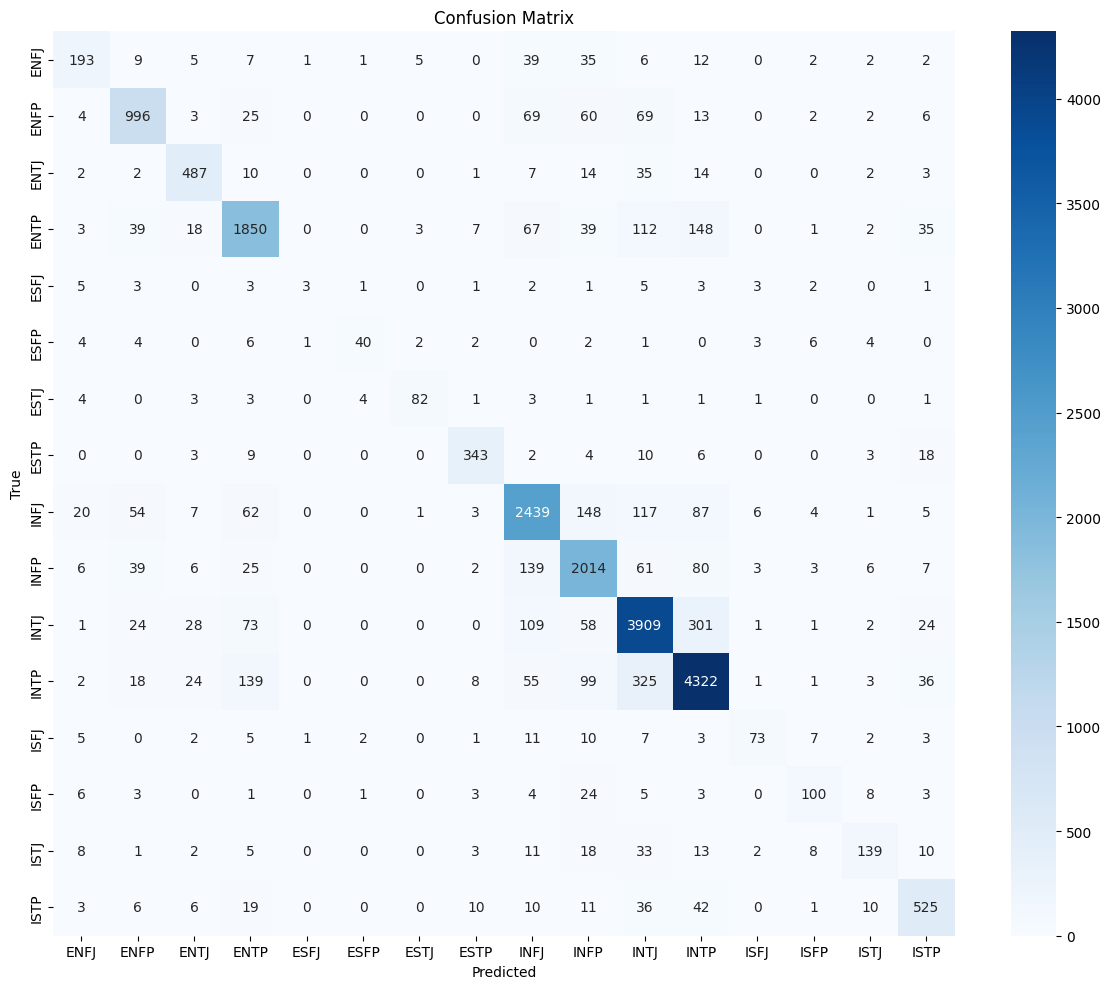

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Collect predictions and true labels
all_preds = []
all_labels = []

# Load the best model
model.load_state_dict(torch.load(os.path.join("LSTM_parameter", "best_model.pth")))
model.eval()

print("Running model evaluation...")
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Collecting predictions"):
        texts = batch['text'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(texts)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Get only the labels that actually appear in the data
unique_labels = np.unique(np.concatenate((all_preds, all_labels)))
target_names = label_encoder.inverse_transform(unique_labels)

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, 
                           target_names=target_names, zero_division=0))

# Calculate F1 scores
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Create and save confusion matrix visualization
cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()

# Save the confusion matrix visualization
os.makedirs("LSTM_parameter/evaluation", exist_ok=True)
plt.savefig(os.path.join("LSTM_parameter/evaluation", "confusion_matrix.png"))
print("Confusion matrix saved to LSTM_parameter/evaluation/confusion_matrix.png")

# Save evaluation metrics
with open(os.path.join("LSTM_parameter/evaluation", "metrics.txt"), 'w') as f:
    f.write(f"Macro F1 Score: {macro_f1:.4f}\n")
    f.write(f"Weighted F1 Score: {weighted_f1:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(all_labels, all_preds, labels=unique_labels, 
                               target_names=target_names, zero_division=0))
    
print("Evaluation metrics saved to LSTM_parameter/evaluation/metrics.txt")

In [ ]:
import torch
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
try:
    model_path = os.path.join("LSTM_parameter", "best_model.pth")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Load tokenizer and label encoder
try:
    tokenizer_path = os.path.join("LSTM_parameter", "tokenizer.pkl")
    label_encoder_path = os.path.join("LSTM_parameter", "label_encoder.pkl")
    
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    with open(label_encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)
    
    print("Tokenizer and LabelEncoder loaded successfully.")
except Exception as e:
    print(f"Error loading Tokenizer or LabelEncoder: {e}")

# Keep the max length consistent with training
MAX_LEN = 500  # Updated to match the hyperparameter value

# Create input text field
text_input = widgets.Textarea(
    value='',
    placeholder='Enter text for MBTI prediction...',
    description='Input:',
    layout=widgets.Layout(width='500px', height='150px')
)

# Create buttons and output area
predict_button = widgets.Button(
    description="Predict", 
    button_style='primary',
    layout=widgets.Layout(width='120px')
)
exit_button = widgets.Button(
    description="Exit", 
    button_style='danger',
    layout=widgets.Layout(width='120px')
)
output = widgets.Output()

# MBTI type descriptions for better interpretation
mbti_descriptions = {
    'INTJ': 'Architect - Strategic thinkers with innovative ideas',
    'INTP': 'Logician - Innovative inventors with an unquenchable thirst for knowledge',
    'ENTJ': 'Commander - Bold, imaginative and strong-willed leaders',
    'ENTP': 'Debater - Smart and curious thinkers who cannot resist an intellectual challenge',
    'INFJ': 'Advocate - Quiet and mystical, yet inspiring and tireless idealists',
    'INFP': 'Mediator - Poetic, kind and altruistic people, always eager to help a good cause',
    'ENFJ': 'Protagonist - Charismatic and inspiring leaders, able to mesmerize their listeners',
    'ENFP': 'Campaigner - Enthusiastic, creative and sociable free spirits',
    'ISTJ': 'Logistician - Practical and fact-minded individuals, reliable and responsible',
    'ISFJ': 'Defender - Very dedicated and warm protectors, always ready to defend their loved ones',
    'ESTJ': 'Executive - Excellent administrators, unsurpassed at managing things or people',
    'ESFJ': 'Consul - Extraordinarily caring, social and popular people',
    'ISTP': 'Virtuoso - Bold and practical experimenters, masters of all kinds of tools',
    'ISFP': 'Adventurer - Flexible and charming artists, ready to explore and experience the world',
    'ESTP': 'Entrepreneur - Smart, energetic and perceptive people',
    'ESFP': 'Entertainer - Spontaneous, energetic and enthusiastic entertainers'
}

# Prediction function
def predict_mbti(b):
    with output:
        output.clear_output()
        user_input = text_input.value.strip()
        
        if not user_input:
            print("⚠️ Please enter some text!")
            return
        
        try:
            # Text preprocessing
            sequence = tokenizer.texts_to_sequences([user_input])
            padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post')
            texts = torch.tensor(padded_sequence, dtype=torch.long).to(device)
            
            # Model prediction
            with torch.no_grad():
                outputs = model(texts)
                predicted_label = outputs.argmax(1).item()
                predicted_mbti = label_encoder.inverse_transform([predicted_label])[0]
            
            # Get prediction probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)[0]
            confidence = probs[predicted_label].item() * 100
            
            # Display results
            print("🧠 MBTI Prediction Results:")
            print(f"👉 Your MBTI type is: {predicted_mbti} (Confidence: {confidence:.2f}%)")
            print(f"📝 Type Description: {mbti_descriptions.get(predicted_mbti, 'No description available')}")
            
            # Show top 3 predictions if confidence is low
            if confidence < 70:
                print("\n🔄 Alternative possibilities:")
                top_indices = torch.topk(probs, 3).indices.cpu().numpy()
                for idx in top_indices:
                    if idx != predicted_label:  # Skip the top prediction which was already shown
                        alt_mbti = label_encoder.inverse_transform([idx])[0]
                        alt_conf = probs[idx].item() * 100
                        print(f"  • {alt_mbti} ({alt_conf:.2f}%): {mbti_descriptions.get(alt_mbti, '')}")
                        
        except Exception as e:
            print(f"❌ Error during prediction: {e}")

# Exit function simulation
def exit_notebook(b):
    with output:
        output.clear_output()
        print("📌 Interface closed. You can safely close or stop the notebook.")

# Bind button events
predict_button.on_click(predict_mbti)
exit_button.on_click(exit_notebook)

# Create button layout
button_layout = widgets.HBox([predict_button, exit_button])

# Display interface
print("MBTI Personality Type Predictor")
print("Enter some text to predict the MBTI personality type.")
display(text_input, button_layout, output)

Using device: cuda
Model loaded successfully.
Tokenizer and LabelEncoder loaded successfully.
MBTI Personality Type Predictor
Enter some text to predict the MBTI personality type.


Textarea(value='', description='Input:', layout=Layout(height='150px', width='500px'), placeholder='Enter text…

Output()